In [6]:
import "dotenv/config";
import { ChatBedrockConverse } from "@langchain/aws";

const model = new ChatBedrockConverse({
  model: "us.amazon.nova-micro-v1:0",
  region: Deno.env.BEDROCK_AWS_REGION ?? "us-east-1",
  credentials: {
    secretAccessKey: Deno.env.BEDROCK_AWS_SECRET_ACCESS_KEY ?? "",
    accessKeyId: Deno.env.BEDROCK_AWS_ACCESS_KEY_ID ?? "",
  },
  temperature: 0,
});


[Module: null prototype] { default: {}, "module.exports": {} }

In [7]:
import { Annotation, MessagesAnnotation } from "@langchain/langgraph";

const StateAnnotation = Annotation.Root({
  ...MessagesAnnotation.spec,
  nextRepresentative: Annotation<string>,
  refundAuthorized: Annotation<boolean>,
});


In [42]:
import { z } from "zod";

const initialSupportOutputSchema = z.object({
  nextRepresentative: z.enum(["BILLING", "TECHNICAL", "RESPOND"]),
});

const initialSupport = async (state: typeof StateAnnotation.State) => {
  const SYSTEM_TEMPLATE = `You are frontline support staff for LangCorp, a company that sells computers. Be concise in your responses. You can chat with customers and help them with basic questions, but if the customer is having a billing or technical problem, do not try to answer the question directly or gather information. Instead, immediately transfer them to the billing or technical team by asking the user to hold for  a moment. Otherwise, just respond conversationally.`;
  const supportResponse = await model.invoke([
    { role: "system", content: SYSTEM_TEMPLATE },
    ...state.messages,
  ]);

  const CATEGORIZATION_SYSTEM_TEMPLATE = `You are an export customer support routing system. Your job is to detect whether a customer support representative is routing a user to a billing team or a technical team, or if the are just responding conversationally.`;
  const CATEGORIZATION_HUMAN_TEMPLATE = `The previous conversation is an interaction between a customer support reqresentative and a user. Extract whether the representative is routing the user to a billing or technical team, or whether the are just responding conversationally. Respond with a JSON object containing a single key called "nextRepresentative" with one of the following values:

  If they want to route the user to the billing team, respond only with the word "BILLING".
  If they want to route the user to the technical team, respond only with the word "TECHNICAL".
  Otherwise, respond only with the word "RESPOND".`;

  const categorizationResponse = await model
    .withStructuredOutput(initialSupportOutputSchema)
    .invoke([
      { role: "system", content: CATEGORIZATION_SYSTEM_TEMPLATE },
      ...state.messages,
      { role: "user", content: CATEGORIZATION_HUMAN_TEMPLATE },
    ]);

  // Will append the response message to the current interaction state
  return {
    messages: [supportResponse],
    nextRepresentative: categorizationResponse.nextRepresentative,
  };
};


In [43]:
const billingSupportOutputSchema = z.object({
  nextRepresentative: z.enum(["REFUND", "RESPOND"]),
});

const billingSupport = async (state: typeof StateAnnotation.State) => {
  const SYSTEM_TEMPLATE = `You are an export billing support specialist for LangCorp, a company that sells computers. Help the user to the best of your ability, but be concise in your responses. You have the ability to authorize refunds, which you can do by transferring the user to another agent who will collect the required information. If you do, assume the other other agent has all necessary information about the customer and their order. You do not need to ask the user for more information.

  Help the user to the best of your ability, but be concise in your response.`;

  let trimmedHistory = state.messages;
  // Make the user's question the most recent message in the history.
  // This helps small models stay focused.
  if (trimmedHistory.at(-1)._getType() === "ai") {
    trimmedHistory = trimmedHistory.slice(0, -1);
  }

  const billingRepResponse = await model.invoke([
    {
      role: "system",
      content: SYSTEM_TEMPLATE,
    },
    ...trimmedHistory,
  ]);

  const CATEGORIZATION_SYSTEM_TEMPLATE = `Your job is to detect whether a billing support representative wants to refund the user.`;
  const CATEGORIZATION_HUMAN_TEMPLATE = `The following text is a response from a customer support representative. Extract whether they want to refund the user or not. Respond with a JSON object containing a single key called "nextRepresentative" with one of the following values:

  If they want to refund the user, respond only with the word "REFUND".
  Otherwise, respond only with the word "RESPOND".

  Here is the text:

  <text>
  ${billingRepResponse.content}
  </text>`;
  const categorizationResponse = await model
    .withStructuredOutput(billingSupportOutputSchema)
    .invoke([
      { role: "system", content: CATEGORIZATION_SYSTEM_TEMPLATE },
      { role: "user", content: CATEGORIZATION_HUMAN_TEMPLATE },
    ]);

  return {
    messages: billingRepResponse,
    nextRepresentative: categorizationResponse.nextRepresentative,
  };
};


In [44]:
const technicalSupport = async (state: typeof StateAnnotation.State) => {
  const SYSTEM_TEMPLATE = `You are an export at diagnosing technical computer issues. You work for a company called LangCorp that sells computers. Help the user to the best of your ability, but be concise in your response.`;

  let trimmedHistory = state.messages;
  // Make the user's question the most recent message in the history.
  // This helps small models stay focused.
  if (trimmedHistory.at(-1)._getType() === "ai") {
    trimmedHistory = trimmedHistory.slice(0, -1);
  }

  const response = await model.invoke([
    { role: "system", content: SYSTEM_TEMPLATE },
    ...trimmedHistory,
  ]);

  return {
    messages: response,
  };
};


In [45]:
import { NodeInterrupt} from "@langchain/langgraph";

const handleRefund = async (state: StateAnnotation.State) => {
  if (!state.refundAuthorized) {
    console.log("--- HUMAN AUTHORIZATION REQUIRED FOR REFUND ---");
    throw new NodeInterrupt("Human authorization required.")
  }
  return {
    messages: {
      role: "assistant",
      content: "Refund processed!"
    }
  }
}

In [46]:
import { StateGraph } from "@langchain/langgraph";

let builder = new StateGraph(StateAnnotation)
  .addNode("initialSupport", initialSupport)
  .addNode("billingSupport", billingSupport)
  .addNode("technicalSupport", technicalSupport)
  .addNode("handleRefund", handleRefund)
  .addEdge("__start__", "initialSupport")

In [47]:
builder = builder.addConditionalEdges(
  "initialSupport",
  async (state: StateAnnotation.State) => {
    if (state.nextRepresentative.includes("BILLING")) {
      return "billing";
    } else if (state.nextRepresentative.includes("TECHNICAL")) {
      return "technical";
    } else {
      return "conversational";
    }
  },
  {
    billing: "billingSupport",
    technical: "technicalSupport",
    conversational: "__end__",
  }
);

console.log("Added edges!");


Added edges!


In [48]:
builder = builder.addEdge("technicalSupport", "__end__").addConditionalEdges("billingSupport", async (state) => {
  if (state.nextRepresentative.includes("REFUND")) {
    return "refund"
  } else {
    return "__end__"
  }
}, {
  refund: "handleRefund",
  __end__: "__end__",
})
.addEdge("handleRefund", "__end__");

console.log("Added edges!");

Added edges!


In [49]:
import { MemorySaver } from "@langchain/langgraph";

const checkpointer = new MemorySaver();

const graph = builder.compile({ checkpointer });


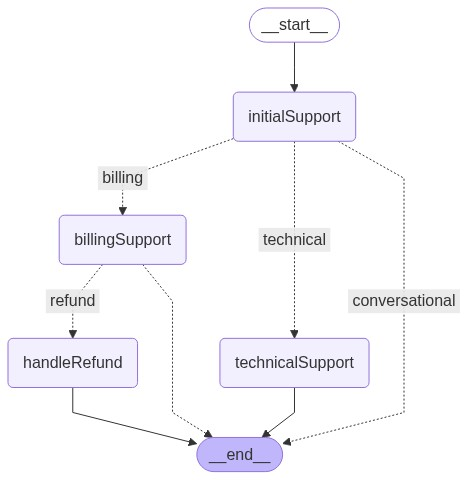

In [50]:
const representation = graph.getGraph();
const image = await representation.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

Deno.jupyter.image(new Uint8Array(arrayBuffer));

In [51]:
const stream = await graph.stream({
  messages: [
    {
      role: "user",
      content: "I've changed my mind and I want to refund for order #182818!",
    }
  ]
}, {
  configurable: {
    thread_id: "refund_testing_id"
  }
});

for await (const value of stream) {
  console.log("---STEP---");
  console.log(value);
  console.log("---END STEP---");
}

---STEP---
{
  initialSupport: {
    messages: [
      AIMessage {
        "id": "5b137d27-a68d-4bbb-889c-b462487ea8c2",
        "content": "Please hold for a moment while I transfer you to our billing team for your refund request.",
        "additional_kwargs": {},
        "response_metadata": {
          "$metadata": {
            "httpStatusCode": 200,
            "requestId": "5b137d27-a68d-4bbb-889c-b462487ea8c2",
            "attempts": 1,
            "totalRetryDelay": 0
          },
          "metrics": {
            "latencyMs": 476
          },
          "stopReason": "end_turn",
          "usage": {
            "inputTokens": 107,
            "outputTokens": 18,
            "totalTokens": 125
          }
        },
        "tool_calls": [],
        "invalid_tool_calls": [],
        "usage_metadata": {
          "input_tokens": 107,
          "output_tokens": 18,
          "total_tokens": 125
        }
      }
    ],
    nextRepresentative: "BILLING"
  }
}
---END STEP---
---S

In [52]:
const currentState = await graph.getState({
  configurable: { thread_id: "refund_testing_id" },
});
console.log("CURRENT TASKS", JSON.stringify(currentState.tasks, null, 2));


CURRENT TASKS [
  {
    "id": "0a707ca5-f961-5fa8-83b0-12fe2420259e",
    "name": "handleRefund",
    "path": [
      "__pregel_pull",
      "handleRefund"
    ],
    "interrupts": [
      {
        "value": "Human authorization required.",
        "when": "during"
      }
    ]
  }
]


In [53]:
console.log("NEXT TASKS", currentState.next);

NEXT TASKS [ "handleRefund" ]


In [ ]:
await graph.updateState(
  { configurable: { thread_id: "refund_testing_id" } },
  { refundAuthorized: true }
);

const resumedStream = await graph.stream(null, {
  configurable: { thread_id: "refund_testing_id" },
});

for await (const value of resumedStream) {
  console.log(value);
}


{
  handleRefund: { messages: { role: "assistant", content: "Refund processed!" } }
}


In [55]:
const technicalStream = await graph.stream(
  {
    messages: [
      {
        role: "user",
        content:
          "My LangCorp computer isn't turning on because I dropped it in water.",
      },
    ],
  },
  {
    configurable: {
      thread_id: "technical_testing_id",
    },
  }
);

for await (const value of technicalStream) {
  console.log(value);
}


{
  initialSupport: {
    messages: [
      AIMessage {
        "id": "a01cd800-dc05-469c-b924-946ae11b0d2d",
        "content": "Sorry to hear that. I'll transfer you to our technical team right away. Please hold for a moment.",
        "additional_kwargs": {},
        "response_metadata": {
          "$metadata": {
            "httpStatusCode": 200,
            "requestId": "a01cd800-dc05-469c-b924-946ae11b0d2d",
            "attempts": 1,
            "totalRetryDelay": 0
          },
          "metrics": {
            "latencyMs": 486
          },
          "stopReason": "end_turn",
          "usage": {
            "inputTokens": 102,
            "outputTokens": 23,
            "totalTokens": 125
          }
        },
        "tool_calls": [],
        "invalid_tool_calls": [],
        "usage_metadata": {
          "input_tokens": 102,
          "output_tokens": 23,
          "total_tokens": 125
        }
      }
    ],
    nextRepresentative: "RESPOND"
  }
}


In [56]:
const conversationalStream = await graph.stream(
  {
    messages: [
      {
        role: "user",
        content: "How are you? I'm Cobb.",
      },
    ],
  },
  {
    configurable: {
      thread_id: "conversational_testing_id",
    },
  }
);

for await (const value of conversationalStream) {
  console.log(value);
}


{
  initialSupport: {
    messages: [
      AIMessage {
        "id": "9cb0d7a3-1af3-4ee9-8fa1-a9a72c803839",
        "content": "Hi Cobb! I'm doing well, thank you. If you have any questions about our products, I'm here to help. If it's about billing or technical issues, I'll connect you with the right team. Just hold for a moment, please.",
        "additional_kwargs": {},
        "response_metadata": {
          "$metadata": {
            "httpStatusCode": 200,
            "requestId": "9cb0d7a3-1af3-4ee9-8fa1-a9a72c803839",
            "attempts": 1,
            "totalRetryDelay": 0
          },
          "metrics": {
            "latencyMs": 679
          },
          "stopReason": "end_turn",
          "usage": {
            "inputTokens": 95,
            "outputTokens": 56,
            "totalTokens": 151
          }
        },
        "tool_calls": [],
        "invalid_tool_calls": [],
        "usage_metadata": {
          "input_tokens": 95,
          "output_tokens": 56,
     